In [2]:
!wget -O imdb.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1vrQ5czMHoO3pEnmofFskymXMkq_u1dPc"
!unzip imdb.zip
!pip -q install eli5
!pip -q install spacy
!python -m spacy download en

Archive:  imdb.zip
  inflating: test.tsv                
  inflating: train.tsv               
     |████████████████████████████████| 216 kB 5.2 MB/s 
     |████████████████████████████████| 133 kB 51.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.
2022-09-03 15:50:31.975458: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 5.3 MB/s 
✔ Download and installation successful
You can now load the package via spacy.loa

# Классификация текстов

Начнём с самого простого - анализа тональности текста.

Будем классифицировать отзывы с IMDB на положительные/отрицательные.

Датасет взят с http://ai.stanford.edu/~amaas/data/sentiment/

In [3]:
!head train.tsv

is_positive	review
0	"Dreamgirls, despite its fistful of Tony wins in an incredibly weak year on Broadway, has never been what one would call a jewel in the crown of stage musicals. However, that is not to say that in the right cinematic hands it could not be fleshed out and polished into something worthwhile on-screen. Unfortunately, what transfers to the screen is basically a slavishly faithful version of the stage hit with all of its inherent weaknesses intact. First, the score has never been one of the strong points of this production and the film does not change that factor. There are lots of songs (perhaps too many?), but few of them are especially memorable. The closest any come to catchy tunes are the title song and One Night Only - the much acclaimed And I Am Telling You That I Am Not Going is less a great song than it is a dramatic set piece for the character of Effie (Jennifer Hudson). The film is slick and technically well-produced, but the story and characters are surprisi

In [4]:
import pandas as pd

train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

print('Train size = {}'.format(len(train_df)))
print('Test size = {}'.format(len(test_df)))

Train size = 25000
Test size = 25000


Посмотрите глазами на тексты? Какие есть зацепки, как определить, что это за сентимент?

Самое простое, как всегда - найти ключевые слова.

In [5]:
#@title Начинаем классифицировать! { vertical-output: true, display-mode: "form" }
positive_words = 'love', 'great', 'best', 'wonderful' #@param {type:"raw"}
negative_words = 'worst', 'awful', '1/10', 'crap' #@param {type:"raw"}

positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))
if accuracy > 0.71:
    from IPython.display import Image, display
    display(Image('https://s3.amazonaws.com/achgen360/t/rmmoZsub.png', width=500))

Test accuracy = 66.73%


**Задание** Придумайте хорошие ключевые слова или фразы и наберите хотя бы 71% точности на тесте (и не забудьте посмотреть на код классификации!)

In [6]:
#@title Подбираем слова { vertical-output: true, display-mode: "form" }
positive_words = 'love', 'great', 'best', 'wonderful', '10/10', 'amazing', 'recommend', 'entertaining', 'super', 'popular' #@param {type:"raw"}
negative_words = 'worst', 'awful', '1/10', 'crap', 'bad', 'weak', 'fail', 'sleep', 'dull', 'below', 'random' #@param {type:"raw"}

positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))
# if accuracy > 0.71:
#     from IPython.display import Image, display
#     display(Image('https://s3.amazonaws.com/achgen360/t/rmmoZsub.png', width=500))

Test accuracy = 71.11%


**Задание** Кому-нибудь нравятся эти `<br /><br />`? Лично мне - нет. Напишите регулярку, которая будет их удалять

In [7]:
import re

pattern = re.compile('<br />')

print(train_df['review'].iloc[3])
print(pattern.subn(' ', train_df['review'].iloc[3])[0])

Spoilers ahead if you want to call them that...<br /><br />I would almost recommend this film just so people can truly see a 1/10. Where to begin, we'll start from the top...<br /><br />THE STORY: Don't believe the premise - the movie has nothing to do with abandoned cars, and people finially understanding what the mysterious happenings are. It's a draub, basic, go to cabin movie with no intensity or "effort".<br /><br />THE SCREENPLAY: I usually give credit to indie screenwriters, it's hard work when you are starting out...but this is crap. The story is flat - it leaves you emotionless the entire movie. The dialogue is extremely weak and predictable boasting lines of "Woah, you totally freaked me out" and "I was wondering if you'd uh...if you'd like to..uh, would you come to the cabin with me?". It makes me want to rip out all my hair, one strand at a time and feed it to myself.<br /><br />THE CHARACTERS: HOLY CRAP!!!! Some have described the characters as flat, I want to take it one 

Применим ее:

In [8]:
train_df['review'] = train_df['review'].apply(lambda text: pattern.subn(' ', text)[0])
test_df['review'] = test_df['review'].apply(lambda text: pattern.subn(' ', text)[0])

Пора переходить к машинке!

Как будем представлять текст? Проще всего - мешком слов.

Заведём большой-большой словарь - список всех слов в обучающей выборке. Тогда каждое предложение можно представить в виде вектора, в котором будет записано, сколько раз встретилось каждое из возможных слов:

![bow](https://raw.githubusercontent.com/DanAnastasyev/DeepNLP-Course/master/Week%2001/Images/BOW.png)

Простой и приятный способ сделать это - запихнуть тексты в `CountVectorizer`.

Он имеет такую сигнатуру:

```python
CountVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern=r'(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class ‘numpy.int64'>)
```

Для начала обратим внимание на параметры `lowercase=True` и `max_df=1.0, min_df=1, max_features=None` - они про то, что по умолчанию все слова будут приводиться к нижнему регистру и в словарь попадут все слова, встречавшиеся в текстах.

При желании можно было бы убрать слишком редкие или слишком частотные слова - пока не будем этого делать.

Посмотрим на простом примере, как он будет работать:

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

dummy_data = ['The movie was excellent',
              'the movie was awful']

dummy_matrix = vectorizer.fit_transform(dummy_data)

print(dummy_matrix.toarray())
print(vectorizer.get_feature_names_out())

[[0 1 1 1 1]
 [1 0 1 1 1]]
['awful' 'excellent' 'movie' 'the' 'was']


*Как именно vectorizer определяет границы слов? Обратите внимание на параметр `token_pattern=r'(?u)\b\w\w+\b'` - как он будет работать?*

Запустим его на реальных данных:

In [10]:
vectorizer = CountVectorizer()
vectorizer.fit(train_df['review'].values)

CountVectorizer()

Посмотрим на слова, попавшие в словарь:

In [11]:
vectorizer.get_feature_names_out()[:15]

array(['00', '000', '0000000000001', '00001', '00015', '000s', '001',
       '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am'],
      dtype=object)

Попробуем кого-нибудь таки сконвертировать

In [12]:
vectorizer.transform([train_df['review'].iloc[3]])

<1x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 206 stored elements in Compressed Sparse Row format>

То, что и хотели - вектор с bow (т.е. bag-of-words) представлением исходного текста.

И чем эта информация может помочь? Ну, всё тем же - какие-то слова носят положительный окрас, какие-то - отрицательный. Большинство вообще нейтральный, да.

![bow with weights](https://github.com/DanAnastasyev/DeepNLP-Course/raw/master/Week%2001/Images/BOW_weights.png)

Хочется, наверное, подобрать коэффициенты, которые будут определять уровень окраса, да? Подбирать нужно по обучающей выборке, а не как мы перед этим делали.

Например, для выборки
```
1   The movie was excellent
0   the movie was awful
```
легко подобрать коэффициенты на глазок: что-нибудь вроде `+1` для `excellent`,  `-1` для `awful` и по нулям всем остальным.

Построим линейную модель, которая станет этим заниматься. Она будет учиться строить разделяющую гиперплоскость в пространстве bow-векторов.

Проверим, как справится логистическая регрессия с нашей супер-выборкой из пары предложений

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

dummy_data = ['The movie was excellent',
              'the movie was awful']
dummy_labels = [1, 0]

vectorizer = CountVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(dummy_data, dummy_labels)

print(vectorizer.get_feature_names_out())
print(classifier.coef_)

['awful' 'excellent' 'movie' 'the' 'was']
[[-0.40104279  0.40104279  0.          0.          0.        ]]


Получилось что надо.

Запустим теперь её на реальных данных.

In [14]:
model.fit(train_df['review'], train_df['is_positive'])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', LogisticRegression())])

In [15]:
from sklearn.metrics import accuracy_score

def eval_model(model, test_df):
    preds = model.predict(test_df['review'])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))
    
eval_model(model, test_df)

Test accuracy = 86.50%


Прогресс!

Хочется как-то посмотреть, что заинтересовало классификатор. К счастью, сделать это совсем просто:

In [16]:
import eli5
eli5.show_weights(classifier, vec=vectorizer, top=40)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+1.855,refreshing
+1.760,wonderfully
+1.689,funniest
+1.647,surprisingly
+1.626,rare
+1.432,superb
+1.401,excellent
+1.365,incredible
+1.351,perfect
+1.302,delightful


Посмотрим на конкретные примеры его работы:

In [17]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [18]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[6], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Посмотрим на примеры неправильной классификации, наконец:

In [19]:
import numpy as np

preds = model.predict(test_df['review'])
incorrect_pred_index = np.random.choice(np.where(preds != test_df['is_positive'])[0])

eli5.show_prediction(classifier, test_df['review'].iloc[incorrect_pred_index],
                     vec=vectorizer, targets=['positive'], target_names=['negative', 'positive'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Придумываем новые признаки

### Tf-idf

Сейчас мы на все слова смотрим с одинаковым весом - хотя какие-то из них более редкие, какие-то более частые, и эта частотность - полезная, вообще говоря, информация.

Самый простой способ добавить статистическую информацию о частотностях - сделать *tf-idf* взвешивание:

$$\text{tf-idf}(t, d) = \text{tf}(t, d) \times \text{idf}(t)$$

*tf* - term-frequency - частотность слова `t` в конкретном документе `d` (рецензии в нашем случае). Это ровно то, что мы уже считали.

*idf* - inverse document-frequency - коэффициент, который тем больше, чем в меньшем числе документов встречалось данное слово. Считается как-нибудь так:
$$\text{idf}(t) = \text{log}\frac{1 + n_d}{1 + n_{d(t)}} + 1$$
где $n_d$ - число всех документов, а $n_{d(t)}$ - число документов со словом `t`.

Использовать его просто - нужно заменить `CountVectorizer` на `TfidfVectorizer`.

**Задание** Попробуйте запустить `TfidfVectorizer`. Посмотрите на ошибки, которые он научился исправлять, и на ошибки, которые он начал делать - по сравнению с `CountVectorizer`.

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.28%


Видим, что для предложения ниже чуть-чуть снизилась вероятность по сравнению с `CountVectorizer`, однако класс по-прежнему определяется верно.

In [21]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Уверенность новой модели в том, что следующий текст негативный несколько снизилась.

Тем не менее метрика, рассчитанная выше, однозначно указывает, что общее качество модели несколько возросло.

In [22]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[6], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [23]:
eli5.show_weights(classifier, vec=vectorizer, top=20)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Глядя на наиболее значимые токены можно обратить внимание на исчезновение из списка слов "disappointment" и "disappointing", хотя, на мой взгляд, они довольно однозначно указывают на эмоциональную окраску текста.

### N-граммы слов

До сих пор мы смотрели на тексты как на мешок слов - но очевидно, что есть разница между `good movie` и `not good movie`.

Добавим информацию (хоть какую-то) о последовательностях слов - будем извлекать еще и биграммы слов.

В Vectorizer'ах для этого есть параметр `ngram_range=(n_1, n_2)` - он говорит, что нужны n_1-...n_2-граммы.

**Задание** Попробуйте увеличенный range и поинтерпретируйте полученный результат.

In [24]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.64%


Качество модели незначительно улучшилось по сравнению с Tfidf векторайзером для слов. 

In [25]:
eli5.show_weights(classifier, vec=vectorizer, top=20)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### N-граммы символов

Символьные n-граммы дают простой способ выучить полезные корни и суффиксы, не связываясь с этой вашей лингвистикой - только статистика, только хардкор.

Например, слово `badass` мы можем представить в виде такой последовательности триграмм:

`##b #ba bad ada das ass ss# s##`

So interpretable, неправда ли?

Реализовать это дело всё так же просто - нужно поставить `analyzer='char'` в вашем любимом Vectorizer'е и выбрать размер `ngram_range`.

**Задание** Запилите классификатор на n-граммах символов и визуализируйте его.

In [26]:
vectorizer = TfidfVectorizer(ngram_range=(2, 6), max_features=20000, analyzer='char')
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Test accuracy = 87.86%


Как видим качество модели немного снизилось, но при этом стоит отметить, что она уперлась в лимит максимального количества итераций в логистической регрессии. Теоретически можно его расширить и посмотреть какого результата удастся добиться в этом случае.

In [27]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Подключаем лингвистику

### Лемматизация и стемминг

Если присмотреться, можно найти формы одного слова с разной семантической окраской по мнению классификатора. Или нет?

**Задание** Найти формы слова с разной семантической окраской.

Поверя, что они есть, попробуем что-нибудь с этим сделать.

Например, лемматизируем - сведем к начальной форме все слова. Поможет в этом библиотека spacy.

In [28]:
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_sm', disable=['parser'])

docs = [doc for doc in nlp.pipe(train_df.review.values[:50])]

In [29]:
for token in docs[0]:
    print(token.text, token.lemma_, token.ent_iob_, token.ent_type_)

Dreamgirls Dreamgirls O 
, , O 
despite despite O 
its its O 
fistful fistful O 
of of O 
Tony Tony B PERSON
wins win O 
in in O 
an an B DATE
incredibly incredibly I DATE
weak weak I DATE
year year I DATE
on on O 
Broadway Broadway B FAC
, , O 
has have O 
never never O 
been be O 
what what O 
one one O 
would would O 
call call O 
a a O 
jewel jewel O 
in in O 
the the O 
crown crown O 
of of O 
stage stage O 
musicals musical O 
. . O 
However however O 
, , O 
that that O 
is be O 
not not O 
to to O 
say say O 
that that O 
in in O 
the the O 
right right O 
cinematic cinematic O 
hands hand O 
it it O 
could could O 
not not O 
be be O 
fleshed flesh O 
out out O 
and and O 
polished polish O 
into into O 
something something O 
worthwhile worthwhile O 
on on O 
- - O 
screen screen O 
. . O 
Unfortunately unfortunately O 
, , O 
what what O 
transfers transfer O 
to to O 
the the O 
screen screen O 
is be O 
basically basically O 
a a O 
slavishly slavishly O 
faithful faithful

**Задание** Сделайте классификатор на лемматизированных текстах.

Сначала лемматизируем текст, затем обучим модель.

In [30]:
%%time

def lemmatize(text):
  return " ".join(token.lemma_ for token in nlp(text))

train_df['lem_review'] = train_df['review'].apply(lemmatize)
test_df['lem_review'] = test_df['review'].apply(lemmatize)

train_df.head()

CPU times: user 27min 51s, sys: 25.4 s, total: 28min 16s
Wall time: 28min 16s


,is_positive,review,lem_review
0,0,"Dreamgirls, despite its fistful of Tony wins i...","Dreamgirls , despite its fistful of Tony win i..."
1,0,This show comes up with interesting locations ...,this show come up with interesting location as...
2,1,I simply love this movie. I also love the Ramo...,I simply love this movie . I also love the Ram...
3,0,Spoilers ahead if you want to call them that.....,spoiler ahead if you want to call they that .....
4,1,My all-time favorite movie! I have seen many m...,my all - time favorite movie ! I have see many...


In [31]:
def eval_model(model, test_df, column_name='review'):
    preds = model.predict(test_df[column_name])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))


vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['lem_review'], train_df['is_positive'])

eval_model(model, test_df, column_name='lem_review')

Test accuracy = 88.16%




Более простой способ нормализации слов - использовать стемминг. Он немного тупой, не учитывает контекст, но иногда оказывается даже эффективнее лемматизации - а, главное, быстрее.

По сути это просто набор правил, как обрезать слово, чтобы получить основу (stem):

In [32]:
from nltk import PorterStemmer

stemmer = PorterStemmer()

print(stemmer.stem('become'))
print(stemmer.stem('becomes'))
print(stemmer.stem('became'))

becom
becom
becam


**Задание** Попробуйте вместо лемм классифицировать основы.

Аналогично проведем процедуру стемминга, а затем обучим модель.

In [33]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')

def stem(text):
    return " ".join(stemmer.stem(token) for token in word_tokenize(text))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [34]:
%%time

train_df['stem_review'] = train_df['review'].apply(stem)
test_df['stem_review'] = test_df['review'].apply(stem)

train_df.head()

CPU times: user 5min 9s, sys: 789 ms, total: 5min 10s
Wall time: 5min 10s


,is_positive,review,lem_review,stem_review
0,0,"Dreamgirls, despite its fistful of Tony wins i...","Dreamgirls , despite its fistful of Tony win i...","dreamgirl , despit it fist of toni win in an i..."
1,0,This show comes up with interesting locations ...,this show come up with interesting location as...,thi show come up with interest locat as fast a...
2,1,I simply love this movie. I also love the Ramo...,I simply love this movie . I also love the Ram...,i simpli love thi movi . i also love the ramon...
3,0,Spoilers ahead if you want to call them that.....,spoiler ahead if you want to call they that .....,spoiler ahead if you want to call them that .....
4,1,My all-time favorite movie! I have seen many m...,my all - time favorite movie ! I have see many...,my all-tim favorit movi ! i have seen mani mov...


In [35]:
vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['stem_review'], train_df['is_positive'])

eval_model(model, test_df, column_name='stem_review')

Test accuracy = 88.12%


Метрика для данного подхода почти идентична результату модели с лемматизацией, которая однако занимает значительно больше времени.

### NER

В текстах рецензий очень много именованных сущностей. Вот, например:

In [36]:
displacy.render(docs[0], style='ent', jupyter=True)

Вообще говоря, почему вдруг какой-нибудь Депп должен нести семантическую окраску? Однако оказывается, что классификатор выучивает, что какие-то имена чаще в положительных рецензиях - или наоборот. Это похоже на переобучение - почему бы не попробовать вырезать сущности?

**Задание** Удалите из текстов какие-то из сущностей, пользуясь координатами из запикленных файлов. Описание сущностей можно посмотреть [здесь](https://spacy.io/api/annotation#named-entities). Запустите классификатор.

Удалим следующие сущности из текстов, чтобы избежать их влияния на процесс обучения - PERSON, ORG, NORP, GPE. Снова сначала проведем обработку текста, а затем обучим модель.

In [37]:
%%time

def clean_ner(text, ner_exclude_list=['PERSON', 'ORG', 'GPE', 'NORP']):
    return " ".join([ent.text for ent in nlp(text) if ent.ent_type_ not in ner_exclude_list])


train_df['ner_exclude_review'] = train_df['review'].apply(clean_ner)
test_df['ner_exclude_review'] = test_df['review'].apply(clean_ner)

train_df.head()

CPU times: user 27min 1s, sys: 14.6 s, total: 27min 15s
Wall time: 27min 13s


,is_positive,review,lem_review,stem_review,ner_exclude_review
0,0,"Dreamgirls, despite its fistful of Tony wins i...","Dreamgirls , despite its fistful of Tony win i...","dreamgirl , despit it fist of toni win in an i...","Dreamgirls , despite its fistful of wins in an..."
1,0,This show comes up with interesting locations ...,this show come up with interesting location as...,thi show come up with interest locat as fast a...,This show comes up with interesting locations ...
2,1,I simply love this movie. I also love the Ramo...,I simply love this movie . I also love the Ram...,i simpli love thi movi . i also love the ramon...,I simply love this movie . I also love the Ram...
3,0,Spoilers ahead if you want to call them that.....,spoiler ahead if you want to call they that .....,spoiler ahead if you want to call them that .....,Spoilers ahead if you want to call them that ....
4,1,My all-time favorite movie! I have seen many m...,my all - time favorite movie ! I have see many...,my all-tim favorit movi ! i have seen mani mov...,My all - time favorite movie ! I have seen man...


In [38]:
vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['ner_exclude_review'], train_df['is_positive'])

eval_model(model, test_df, column_name='ner_exclude_review')

Test accuracy = 88.38%


Удалось добиться небольшого улучшения метрики по сравнению с моделями на основе лемматизации/стемминга.

## Включаем дип лёрнинг

Мы тут пришли deep learning'ом заниматься, а делаем почему-то модель на логистической регрессии. Как так?

Попробуем запустить относительно стандартную модель для классификации текстов - сверточная сеть поверх словных эмбеддингов.

Разбираться, что это за зверь, будем на следующих занятиях, а пока будем просто им пользоваться :)

Каждое предложение нужно представлять набором слов - и сразу же начинаются проблемы. Во-первых, как ограничить длину предложения?

Прикинем по гистограмме, какая длина нам подходит:

In [39]:
train_df['review']

0        Dreamgirls, despite its fistful of Tony wins i...
1        This show comes up with interesting locations ...
2        I simply love this movie. I also love the Ramo...
3        Spoilers ahead if you want to call them that.....
4        My all-time favorite movie! I have seen many m...
                               ...                        
24995    I am a big fan of the movie, but not for the u...
24996    I'm not going to bother with a plot synopsis s...
24997    This movie . . . I don't know. Why they would ...
24998    Saw this film on DVD yesterday and was gob-sma...
24999    This was a disappointment - none of the nuance...
Name: review, Length: 25000, dtype: object

<a list of 231 Patch objects>

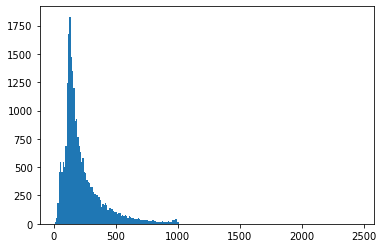

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(train_df.review.apply(lambda text: len(text.split())), bins='auto')
hist

Кроме этого, нужно перенумеровать как-то слова.

In [41]:
from collections import Counter

words_counter = Counter((word for text in train_df.review for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 26783


**Задание** Сконвертируйте данные

In [42]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=int)
    
    for inx, text in enumerate(texts):
        result = []
        for word in text.split():
            if word in word2idx:
                result.append(word2idx[word])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=int)
    return data

X_train = convert(train_df.review, word2idx, 1000)
X_test = convert(test_df.review, word2idx, 1000)

Поставим учиться модельку на keras.

*Напоминание*: на keras, чтобы обучить модель, нужно
1. Определить модель, например:
```python 
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=NUM_WORDS))
```
2. Задать функцию потерь и оптимизатор:
```python
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```

3. Запустить обучение:
```python
model.fit(X_train, y_train, 
          batch_size=32,
          epochs=3,
          validation_data=(X_test, y_test))
```

В NLP чаще всего ставятся задачи классификации, поэтому нужно запомнить такие функции потерь:

*   **categorical_crossentropy** - для многоклассовой классификации, в качестве меток должны передаваться one-hot-encoding вектора
*   **sparse_categorical_crossentropy** - аналогично предыдущему, но в качестве меток нужно передавать просто индексы соответствующих классов
*   **binary_crossentropy** - для бинарной классификации


В качестве оптимизатора обычно используют `sgd` или `adam`.


In [43]:
import tensorflow as tf
tf.__version__

'2.8.2'

In [44]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Dropout

In [69]:
model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=10, activation='relu'),

    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 64)          1714112   
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,714,883
Trainable params: 1,714,883
Non-trainable params: 0
____________________________________________

In [70]:
model.fit(X_train, train_df.is_positive, batch_size=128, epochs=10, 
          validation_data=(X_test, test_df.is_positive))

Epoch 1/10
196/196 [==============================] - 18s 90ms/step - loss: 0.5858 - accuracy: 0.7136 - val_loss: 0.3745 - val_accuracy: 0.8453
Epoch 2/10
196/196 [==============================] - 17s 89ms/step - loss: 0.2807 - accuracy: 0.8878 - val_loss: 0.2952 - val_accuracy: 0.8726
Epoch 3/10
196/196 [==============================] - 18s 90ms/step - loss: 0.1667 - accuracy: 0.9393 - val_loss: 0.2974 - val_accuracy: 0.8762
Epoch 4/10
196/196 [==============================] - 18s 91ms/step - loss: 0.0881 - accuracy: 0.9732 - val_loss: 0.3355 - val_accuracy: 0.8721
Epoch 5/10
196/196 [==============================] - 18s 91ms/step - loss: 0.0394 - accuracy: 0.9916 - val_loss: 0.3796 - val_accuracy: 0.8699
Epoch 6/10
196/196 [==============================] - 18s 91ms/step - loss: 0.0161 - accuracy: 0.9979 - val_loss: 0.4208 - val_accuracy: 0.8679
Epoch 7/10
196/196 [==============================] - 18s 91ms/step - loss: 0.0074 - accuracy: 0.9995 - val_loss: 0.4636 - val_accuracy:

**Задание** Подсчитайте качество модели на тесте

In [79]:
preds = tf.round(model.predict(X_test))
print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))

Test accuracy = 86.61%


Качество построенной модели на тесте оказалось хуже, чем в моделях логистической регрессии на основе векторайзеров.

## Домашнее задание

Взять ноутбук colab_text_classification_part1.ipynb который разбирали на занятии и добавить пункты которые мы пропустили 

1. Посмотрите на токены если будут мусорные добавьте их в стоп слова и обучите заново

2. Проверьте изменилось ли качество при лемматизации/и без неё

3. Замените все токены которые принадлежат сущностям на их тег. Проверьте изменилось ли качество после этого


## Решение:

Задания, которые были сформулированы в тексте ноутбука, выполнены выше в рамках ноутбука после формулировкой заданий. 

Среди прочего были построены модели с лемматизацией и стеммингом. Модели показали близкие результаты, но стемминг вполне очевидно отработал быстрее. При этом метрика accuracy для модели с лемматизацией оказалась чуть-чуть хуже аналогичной для модели с простым Tfidf векторайзером.

Также была построена модель с исключением определенных видов именнованных сущностей. Она оказалась лучше простого векторайзера, но чуть-чуть хуже векторайзера на основе N-грамм.

Теперь рассмотрим оставшиеся задания.

1. Попробуем удалить стоп слова из отзывов и обучить логистическую регрессию на изменном датасете.

In [84]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [89]:
%%time

def clean_text(text, sw=stopwords_list):
    return " ".join([token for token in word_tokenize(text) if token not in sw])


train_df['sw_exclude_review'] = train_df['review'].apply(clean_text)
test_df['sw_exclude_review'] = test_df['review'].apply(clean_text)

train_df.head()

CPU times: user 2min 2s, sys: 321 ms, total: 2min 2s
Wall time: 2min 6s


,is_positive,review,lem_review,stem_review,ner_exclude_review,sw_exclude_review
0,0,"Dreamgirls, despite its fistful of Tony wins i...","Dreamgirls , despite its fistful of Tony win i...","dreamgirl , despit it fist of toni win in an i...","Dreamgirls , despite its fistful of wins in an...","Dreamgirls , despite fistful Tony wins incredi..."
1,0,This show comes up with interesting locations ...,this show come up with interesting location as...,thi show come up with interest locat as fast a...,This show comes up with interesting locations ...,This show comes interesting locations fast tra...
2,1,I simply love this movie. I also love the Ramo...,I simply love this movie . I also love the Ram...,i simpli love thi movi . i also love the ramon...,I simply love this movie . I also love the Ram...,"I simply love movie . I also love Ramones , I ..."
3,0,Spoilers ahead if you want to call them that.....,spoiler ahead if you want to call they that .....,spoiler ahead if you want to call them that .....,Spoilers ahead if you want to call them that ....,Spoilers ahead want call ... I would almost re...
4,1,My all-time favorite movie! I have seen many m...,my all - time favorite movie ! I have see many...,my all-tim favorit movi ! i have seen mani mov...,My all - time favorite movie ! I have seen man...,My all-time favorite movie ! I seen many movie...


In [93]:
vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['sw_exclude_review'], train_df['is_positive'])

eval_model(model, test_df, column_name='sw_exclude_review')

Test accuracy = 88.38%


Метрика в точности совпадает с полученной для модели, очищенной от определенных именнованных сущностей. Accuracy чуть лучше, чем в случае моделей с лемматизацией и стеммингом.

2. Выполнено выше в разделе "Подключаем лингвистику".

3. Аналогичным образом сначала предобработаем данные, затем обучим модель и посмотрим на ее качество.

In [117]:
%%time

def ner_mod_review(text):
    return " ".join([ent.ent_type_ if ent.ent_type_ else ent.text for ent in nlp(text)])


train_df['ner_mod_review'] = train_df['review'].apply(ner_mod_review)
test_df['ner_mod_review'] = test_df['review'].apply(ner_mod_review)

train_df.head()

CPU times: user 25min 44s, sys: 44.2 s, total: 26min 28s
Wall time: 26min 31s


,is_positive,review,lem_review,stem_review,ner_exclude_review,sw_exclude_review,ner_mod_review
0,0,"Dreamgirls, despite its fistful of Tony wins i...","Dreamgirls , despite its fistful of Tony win i...","dreamgirl , despit it fist of toni win in an i...","Dreamgirls , despite its fistful of wins in an...","Dreamgirls , despite fistful Tony wins incredi...","Dreamgirls , despite its fistful of PERSON win..."
1,0,This show comes up with interesting locations ...,this show come up with interesting location as...,thi show come up with interest locat as fast a...,This show comes up with interesting locations ...,This show comes interesting locations fast tra...,This show comes up with interesting locations ...
2,1,I simply love this movie. I also love the Ramo...,I simply love this movie . I also love the Ram...,i simpli love thi movi . i also love the ramon...,I simply love this movie . I also love the Ram...,"I simply love movie . I also love Ramones , I ...",I simply love this movie . I also love the Ram...
3,0,Spoilers ahead if you want to call them that.....,spoiler ahead if you want to call they that .....,spoiler ahead if you want to call them that .....,Spoilers ahead if you want to call them that ....,Spoilers ahead want call ... I would almost re...,Spoilers ahead if you want to call them that ....
4,1,My all-time favorite movie! I have seen many m...,my all - time favorite movie ! I have see many...,my all-tim favorit movi ! i have seen mani mov...,My all - time favorite movie ! I have seen man...,My all-time favorite movie ! I seen many movie...,My all - time favorite movie ! I have seen man...


In [120]:
vectorizer = TfidfVectorizer()
classifier = LogisticRegression(max_iter=200)

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['ner_mod_review'], train_df['is_positive'])

eval_model(model, test_df, column_name='ner_mod_review')

Test accuracy = 88.27%


Качество получившейся модели чуть хуже, если сравнивать с построенной в первом пункте.